In [1]:
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram


# 1.  algorytm "half adder" służący do znajdowania wyniku dodawania bitów. Wielokrotne zastosowanie pozwala na zbudowanie algorytmu znajdującego sumę bitową dowolnego ciągu

In [2]:
ha_qc = QuantumCircuit(4, 2)

# poniżej inicjalizujemy dwa dodawane bity w tym przypadku 11. Można uzyskać dowolną kombinację poprzez nie zastosowanie x-gate.
ha_qc.x(0) 
ha_qc.x(1)

#"budowa" układu
ha_qc.cx(0,2) # CNOT gate
ha_qc.cx(1,2) # CNOT gate
ha_qc.ccx(0,1,3) # bramka Toffoliego

# wykonanie pomiaru i wyswietlenie go
ha_qc.measure(2,0)
ha_qc.measure(3,1)
ha_qc.draw()
    

┌───┐                     
q_0: ┤ X ├──■─────────■────────
     ├───┤  │         │        
q_1: ┤ X ├──┼────■────■────────
     └───┘┌─┴─┐┌─┴─┐  │  ┌─┐   
q_2: ─────┤ X ├┤ X ├──┼──┤M├───
          └───┘└───┘┌─┴─┐└╥┘┌─┐
q_3: ───────────────┤ X ├─╫─┤M├
                    └───┘ ║ └╥┘
c: 2/═════════════════════╩══╩═
                          0  1

In [3]:
# wyswietlenie wyniku operacji
sim = AerSimulator()
job = sim.run(ha_qc)  
result = job.result()   
result.get_counts() 

{'10': 1024}

Zasada działania: Przy dodawaniu do siebie liczb w postaci bitów o tej samej długości algorytmicznie sprowadza się to do serii dodawania par bitów według tabelki:\
0+0=00\
0+1=01\
1+0=01\
1+1=10\
Co jest odpowiednikiem "dodawania pod kreską". Powyższy algorytm przyjmując dowolną parę bitów q0 i q1 zwraca wynik przy pomocy 2 bramek CNOT oraz bramki Toffoliego. Układ 2 bramek CNOT ustawia prawy bit outputu na q0 XOR q1, a bramka Toffoliego służy do ustawienia lewego bitu outputu.  

# 2. algorytm szukający Grover'a. Służący do znajdywania stanu spełniającego rozwiązania w nieposortowanej strukturze. 

Wprowadzenie: Pokażemy działanie algorytmu na przykładzie w którym input ustawimy na równą superpozycję stanów 00, 01, 10, 11. Jako rozwiązanie uznamy stan 11. W tym celu tworzymy oracle odwracający fazę tego rozwiązania oraz odpowiadający dyfuzer.

In [4]:
#tworzenie pierwszego elementu układu nazywanego oracle z c-z gate'a i narysowanie go 
oracle = QuantumCircuit(2)
oracle.cz(0,1)  # bramka c-z odwraca faze |11>
oracle.draw()

q_0: ─■─
      │ 
q_1: ─■─

In [5]:
#tworzenie drugiego elementu nazywanego dyfuzerem składającego sie z 2 H-gatów
diffuser = QuantumCircuit(2)
diffuser.h([0, 1]) # bramka Hadamard'a
diffuser.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [6]:
#zastosowanie 2 X-gate'ów do dyfuzera w celu zamiany domyślnego inputu z |00> na |11>
diffuser.x([0,1])
diffuser.draw()

┌───┐┌───┐
q_0: ┤ H ├┤ X ├
     ├───┤├───┤
q_1: ┤ H ├┤ X ├
     └───┘└───┘

In [7]:
diffuser.cz(0,1)
diffuser.x([0,1])
diffuser.h([0,1])
diffuser.draw()

┌───┐┌───┐   ┌───┐┌───┐
q_0: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤├───┤ │ ├───┤├───┤
q_1: ┤ H ├┤ X ├─■─┤ X ├┤ H ├
     └───┘└───┘   └───┘└───┘

In [8]:
grover = QuantumCircuit(2)
grover.h([0,1])  # inicjalizacja stanu równej superpozycji inputów
grover = grover.compose(oracle)
grover = grover.compose(diffuser)
grover.measure_all()
grover.draw()

┌───┐   ┌───┐┌───┐   ┌───┐┌───┐ ░ ┌─┐   
   q_0: ┤ H ├─■─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░─┤M├───
        ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─■─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░──╫─┤M├
        └───┘   └───┘└───┘   └───┘└───┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1

In [9]:
sim = Aer.get_backend('aer_simulator')
sim.run(grover).result().get_counts()

{'11': 1024}

Zasada działania: na tym przykładzie jako input używamy 2 qbitów i zastosujemy na nich działanie pojedyńczej iteracji algorytmu. Algorytm można podzielić na 3 kroki:\
1.tworzymy równą superpozycję wszystkich możliwych inputów dla oracla. W naszym przypadku qubity domyślnie ustawione są na stan |0>, więc tworzymy superpozycje przez przepuszczenie qubitów przez H-gate.\
2.Tak przygotowany input przepuszczamy przez oracle'a. (Układ który odwraca fazę stanów będących rozwiązaniami (szukanymi)).\
3.Ostatecznie przepuszczamy nasz input przez dyfuzer, którego działanie najlepiej opisać poniższym obrazkiem.
Powtarzając kroki 2. i 3. bedzięmy dostawać stan najbardziej zbliżony do superpozycji rozwiązań. \
Działanie algorytmu można w skrócie przedstawić graficznie z wyodrębnieniem roli oracle'a i dyfuzera. Oznaczając stan wyjściowy jako |s> możemy przedstawić go na płaszczyźnie jako superpozycję rozwiązań |+> i nie-rozwiązań |->. Rozpisując zatem |s> = a|-> + b|+> w pierwszym kroku nasz oracle odwracając fazę stanów będących rozwiązaniem zwróci a|-> -b|+> czyli efektywnie odbije wektor |s> względem osi |->. W drugim kroku działa dyfuzer który odbija nowo powstały wektor |s'> względem wektora |s>. Powtarzanie powyrzszych kroków pozwala na zbliżenie się wektora |s> do osi |+> zatem do rozwiązania zagadnienia.

![Grover](Grover.png)

# 3. Algorytm Deutsch-Jozsa

Wprowadzenie: Mamy funkcje logiczną f która przyjmuje ciąg bitów i zwraca 0 albo 1. Jest ona albo stała albo "zbalansowana". Stała-zwraca zawsze 0 albo zawsze 1, zbalansowana - zwraca tyle samo 0 co 1. Zadaniem algorytmu jest znalezienie czy funckja jest stała czy zbalansowana. Przy użyciu algorytmu kwantowego możemy to stwierdzić po tylko jednym wywołaniu funkcji ze 100% pewnością. W naszym doświadczeniu stworzymy 2 oracle, jedno zbalansowane i jedno stałe. Obydwa dołączymy do takiego samego układu pomiarowego który zwraca prawdopodobieństwo tego że podłączony oracle jest stały (000) lub tego że jest zbalansowany (001)

In [10]:
# funkcje f implementujemy jako oracle
oracle_const = QuantumCircuit(4)
oracle_const.x(3) #f stała zawsze zwróci 1

oracle_balanced = QuantumCircuit(4) #f zbalansowana stworzona przy pomocy 3 CNOT gatów
oracle_balanced.cx(0,3)
oracle_balanced.cx(0,2)
oracle_balanced.cx(0,1)

In [11]:
circuit_const = QuantumCircuit(4,3)
for qubit in range(3):   #ustawienie stanu początkowego
    circuit_const.h(qubit)
circuit_const.x(3)
circuit_const.h(3)
circuit_const.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘
c: 3/══════════

In [12]:
#dodajemy oracle
circuit_const = circuit_const.compose(oracle_const)
circuit_const.draw()

┌───┐          
q_0: ┤ H ├──────────
     ├───┤          
q_1: ┤ H ├──────────
     ├───┤          
q_2: ┤ H ├──────────
     ├───┤┌───┐┌───┐
q_3: ┤ X ├┤ H ├┤ X ├
     └───┘└───┘└───┘
c: 3/═══════════════

In [13]:
# powtarzamy H-gates
for qubit in range(3):
    circuit_const.h(qubit)
circuit_const.barrier()
# wykonujemy pomiar
for i in range(3):
    circuit_const.measure(i, i)
    
# wyświetlamy układ
circuit_const.draw()

┌───┐┌───┐      ░ ┌─┐      
q_0: ┤ H ├┤ H ├──────░─┤M├──────
     ├───┤├───┤      ░ └╥┘┌─┐   
q_1: ┤ H ├┤ H ├──────░──╫─┤M├───
     ├───┤├───┤      ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├──────░──╫──╫─┤M├
     ├───┤├───┤┌───┐ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├─░──╫──╫──╫─
     └───┘└───┘└───┘ ░  ║  ║  ║ 
c: 3/═══════════════════╩══╩══╩═
                        0  1  2

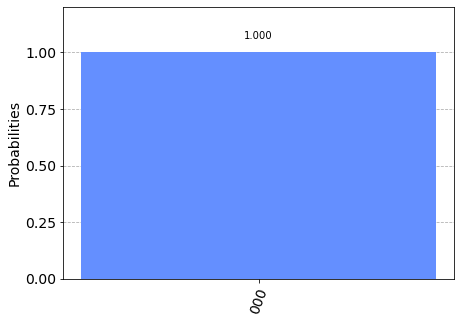

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
results3 = aer_sim.run(circuit_const).result()
answer3 = results3.get_counts()

plot_histogram(answer3)

In [15]:
circuit_balanced = QuantumCircuit(4,3)
for qubit in range(3):   #ustawienie stanu początkowego
    circuit_balanced.h(qubit)
circuit_balanced.x(3)
circuit_balanced.h(3)
circuit_balanced.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘
c: 3/══════════

In [16]:
#dodajemy oracle
circuit_balanced = circuit_balanced.compose(oracle_balanced)
circuit_balanced.draw()

┌───┐                    
q_0: ┤ H ├───────■────■────■──
     ├───┤       │    │  ┌─┴─┐
q_1: ┤ H ├───────┼────┼──┤ X ├
     ├───┤       │  ┌─┴─┐└───┘
q_2: ┤ H ├───────┼──┤ X ├─────
     ├───┤┌───┐┌─┴─┐└───┘     
q_3: ┤ X ├┤ H ├┤ X ├──────────
     └───┘└───┘└───┘          
c: 3/═════════════════════════

In [17]:
# powtarzamy H-gates
for qubit in range(3):
    circuit_balanced.h(qubit)
circuit_balanced.barrier()
# wykonujemy pomiar
for i in range(3):
    circuit_balanced.measure(i, i)
    
# wyświetlamy układ
circuit_balanced.draw()

┌───┐                    ┌───┐ ░ ┌─┐      
q_0: ┤ H ├───────■────■────■──┤ H ├─░─┤M├──────
     ├───┤       │    │  ┌─┴─┐├───┤ ░ └╥┘┌─┐   
q_1: ┤ H ├───────┼────┼──┤ X ├┤ H ├─░──╫─┤M├───
     ├───┤       │  ┌─┴─┐├───┤└───┘ ░  ║ └╥┘┌─┐
q_2: ┤ H ├───────┼──┤ X ├┤ H ├──────░──╫──╫─┤M├
     ├───┤┌───┐┌─┴─┐└───┘└───┘      ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├────────────────░──╫──╫──╫─
     └───┘└───┘└───┘                ░  ║  ║  ║ 
c: 3/══════════════════════════════════╩══╩══╩═
                                       0  1  2

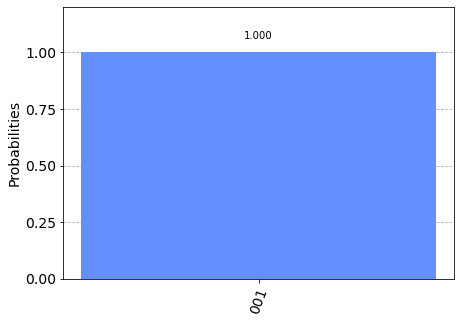

In [18]:
aer_sim = Aer.get_backend('aer_simulator')
results4 = aer_sim.run(circuit_balanced).result()
answer4 = results4.get_counts()

plot_histogram(answer4)

Algorytm poprawnie wykrył który oracle jest funckją stałą a który funkcją zbalansowaną po jednej iteracji. Działa on na zasadzie H-gatów. W przypadku stałego oracla nie ma on efektywnie efektu na stan inputowych qubitów które zostają takie same przed i po przejściu przez oracle. Ponieważ H-gate jest swoją własną operacją odwrotną przepuszczając qubity przez 2 H-gaty otrzymujemy  stan |00...0>.\
W przypadku oracla zbalansowanego po przepuszczeniu przez pierwsze H-gaty nasz input jest następnie przesunięty w fazie w dokładnie połowach dostępnych stanów. Po przejściu przez oracle "sygnał" jest ortogonalny do stanu przed przejściem przez oracla. Z tego powodu po przejściu przez drugie H-gaty nasz stan wyjściowy będzie ortogonalny do |00...0> więc nigdy nie otrzymamy tego stanu.

# 4. Algorytm zdalnie kontrolujący losowanie


Wprowadznie: Algorytm zmienia prawdopodobieństwo zarejestrowania 0 lub 1 w registerze na podstawie stanu qubitu kontrolującego q0. Podzieliliśmy układ na 3 przypadki w którym stan qubitu kontolującego ma stan domyślny |0>, stan |1> oraz w którym został on w stanie |0> przepuszczony przez H-gate co efektywnie daje równą superpozycję stanów |0> i |1> co daje nam równe prawdopodobieństwo odczytania 0 i 1.

In [19]:
#przypadek 1 - qubit kontrolujący q0 w stanie |0>
circuit_random = QuantumCircuit(2,1)

circuit_random.h(1)
circuit_random.t(1)
circuit_random.h(1)
circuit_random.cx(0,1)
circuit_random.measure(1,0)
circuit_random.draw()

q_0: ─────────────────■─────
     ┌───┐┌───┐┌───┐┌─┴─┐┌─┐
q_1: ┤ H ├┤ T ├┤ H ├┤ X ├┤M├
     └───┘└───┘└───┘└───┘└╥┘
c: 1/═════════════════════╩═
                          0

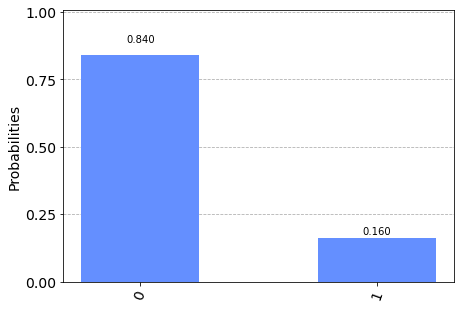

In [20]:
#Rozkład prawdopodobieństwa odczytu w registerze w 1 przypadku 
aer_sim = Aer.get_backend('aer_simulator')
results5 = aer_sim.run(circuit_random).result()
answer5 = results5.get_counts()

plot_histogram(answer5)

In [21]:
#przypadek 2 - qubit kontrolujący q0 w stanie |1>
circuit_random2 = QuantumCircuit(2,1)
circuit_random2.x(0)
circuit_random2.h(1)
circuit_random2.t(1)
circuit_random2.h(1)
circuit_random2.cx(0,1)
circuit_random2.measure(1,0)
circuit_random2.draw()

┌───┐                  
q_0: ┤ X ├────────────■─────
     ├───┤┌───┐┌───┐┌─┴─┐┌─┐
q_1: ┤ H ├┤ T ├┤ H ├┤ X ├┤M├
     └───┘└───┘└───┘└───┘└╥┘
c: 1/═════════════════════╩═
                          0

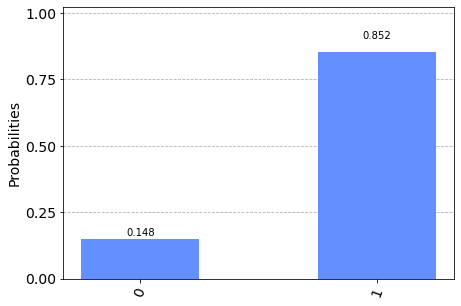

In [22]:
#Rozkład prawdopodobieństwa odczytu w registerze w 2 przypadku 
aer_sim = Aer.get_backend('aer_simulator')
results6 = aer_sim.run(circuit_random2).result()
answer6 = results6.get_counts()

plot_histogram(answer6)

In [23]:
#przypadek 3 - qubit kontrolujący q0 w stanie równej superpozycji |0> i |1>
circuit_random3 = QuantumCircuit(2,2)
circuit_random3.h(0)
circuit_random3.h(1)
circuit_random3.t(1)
circuit_random3.h(1)
circuit_random3.cx(0,1)
circuit_random3.measure(0,0)
circuit_random3.measure(1,1)
circuit_random3.draw()

┌───┐               ┌─┐   
q_0: ┤ H ├────────────■──┤M├───
     ├───┤┌───┐┌───┐┌─┴─┐└╥┘┌─┐
q_1: ┤ H ├┤ T ├┤ H ├┤ X ├─╫─┤M├
     └───┘└───┘└───┘└───┘ ║ └╥┘
c: 2/═════════════════════╩══╩═
                          0  1

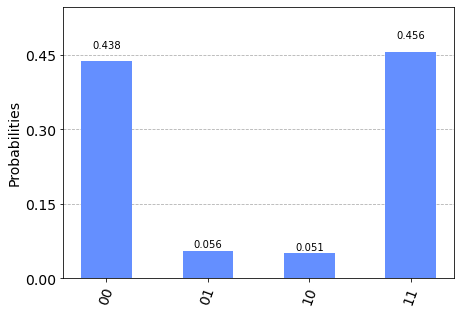

In [24]:
#Rozkład prawdopodobieństwa odczytu w 3 przypadku. Można zauważyć że prawdopodobieństwa warunkowe odczytu bitu drugiego pod warunkiem ustalonego bitu pierwszego pokrywają się z
#przypadkami 1) i 2)
aer_sim = Aer.get_backend('aer_simulator')
results7 = aer_sim.run(circuit_random3).result()
answer7 = results7.get_counts()

plot_histogram(answer7)

Zasada działania: qubit 2 będąc domyślnie ustawionym w stanie |0> przechodzi przez serię bramke H-T-H, (gdzie T-gatę-przesuwa fazę względną o 45 stopni), co zostawia qubit w stanie w którym przy pomiarze prawdopodobieńśtwo uzyskania 0 wynosi ok 0,85, a 1 ok 0,15. Qubit q0 kontrolujący bramkę X na końcu pozwala w zależności od jego stanu zamienić prawdopodobieństwa pomiaru 0 i 1. 